In [ ]:
import kagglehub
dataset_path = kagglehub.dataset_download('riyaelizashaju/skin-disease-classification-image-dataset')

print(dataset_path)

/kaggle/input/skin-disease-classification-image-dataset


### LIBRARIES

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall

from sklearn import metrics
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import os
import requests

### IMAGE DATA GENERATOR

Preprocessing with size 450x450, augmenting with zoom range and flips.

In [ ]:
img_size = (450, 450)

In [ ]:
def data_preprocessing(path):
	datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255,
	                                                          zoom_range=0.2,
																														horizontal_flip=True,
																														vertical_flip=True,
																														)

	generator = datagen.flow_from_directory(
		path,
		batch_size=25,
 		class_mode='categorical',
		target_size=img_size,
		color_mode="rgb"
    )

	return generator

In [ ]:
train_generator = data_preprocessing(dataset_path + "/Split_smol/train")
validation_generator = data_preprocessing(dataset_path + "/Split_smol/val")

Found 697 images belonging to 9 classes.
Found 181 images belonging to 9 classes.


### MODEL

Use LeakyReLU to prevent disappearing ReLU issues. The kernel size is increased in the intermediate layers to capture more generic features. On the other side, the size is 3 for first and last layers, to filter more specific details.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', input_shape=(img_size[0], img_size[1], 3), kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis = -1),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.15),
    tf.keras.layers.BatchNormalization(axis = -1),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(9, activation='softmax')

])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 450, 450, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 450, 450, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 450, 450, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 225, 225, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 225, 225, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 225, 225, 128)       │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 225, 225, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 225, 225, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,856,649 (106.26 MB)

 Trainable params: 27,853,449 (106.25 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
history_model = model.fit(train_generator, epochs = 30, validation_data = validation_generator)

# save the model
model.save('model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.2517 - loss: 2.7105 - precision: 0.3051 - recall: 0.1729 - val_accuracy: 0.1105 - val_loss: 14.9925 - val_precision: 0.1034 - val_recall: 0.0994
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.4370 - loss: 1.7062 - precision: 0.5348 - recall: 0.3006 - val_accuracy: 0.1160 - val_loss: 6.5569 - val_precision: 0.1235 - val_recall: 0.1160
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4532 - loss: 1.5872 - precision: 0.5589 - recall: 0.3648 - val_accuracy: 0.2265 - val_loss: 2.6798 - val_precision: 0.2653 - val_recall: 0.0718
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5133 - loss: 1.4546 - precision: 0.5325 - recall: 0.3838 - val_accuracy: 0.1160 - val_loss: 2.8896 - val_precision: 0.1628 - val_recall: 0.0387
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4889 - loss: 1.4607 - precision: 0.5972 - recall: 0.4093 - val_accuracy: 0.2486 - val_loss: 2.3950 - v

### TEST

In [ ]:
class_names = list(train_generator.class_indices.keys())

def predict_disease(model, img_path):
  img = tf.keras.utils.load_img(img_path, target_size=(img_size[0], img_size[1], 3), color_mode = 'rgb')
  array = tf.keras.utils.img_to_array(img)
  array = array / 255.0

  img_array = np.expand_dims(array, axis=0)
  preds = model.predict(img_array)

  #formatted_predictions = []
  for prediction in preds:
      formatted_predictions = [f'{value:.2f}' for value in prediction]

  top_prob_index = np.argmax(formatted_predictions)
  top_prob = round(float(formatted_predictions[top_prob_index].replace(",", "."))*100, 2)

  print("Probability for each class:", sorted(zip(class_names, formatted_predictions), key=lambda x: x[1], reverse=True))

  plt.imshow(tf.keras.utils.load_img(img_path, target_size=(img_size[0], img_size[1],3), color_mode = 'rgb'))
  plt.axis('off')
  plt.title(f"Class: {list(class_names)[top_prob_index]}; Prob: {top_prob}%")
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Probability for each class: [('Actinic keratosis', '0.76'), ('Dermatofibroma', '0.14'), ('Squamous cell carcinoma', '0.09'), ('Tinea Ringworm Candidiasis', '0.01'), ('Atopic Dermatitis', '0.00'), ('Benign keratosis', '0.00'), ('Melanocytic nevus', '0.00'), ('Melanoma', '0.00'), ('Vascular lesion', '0.00')]


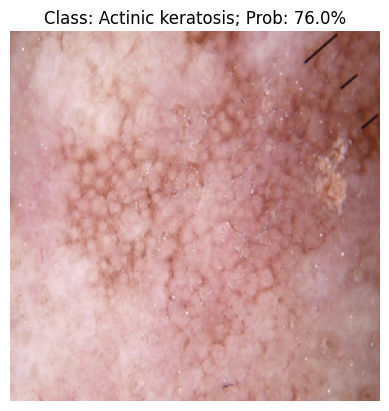

In [ ]:
predict_disease(model, dataset_path + "/Split_smol/val/Actinic keratosis/ISIC_0025825.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Probability for each class: [('Tinea Ringworm Candidiasis', '0.78'), ('Atopic Dermatitis', '0.21'), ('Melanoma', '0.01'), ('Actinic keratosis', '0.00'), ('Benign keratosis', '0.00'), ('Dermatofibroma', '0.00'), ('Melanocytic nevus', '0.00'), ('Squamous cell carcinoma', '0.00'), ('Vascular lesion', '0.00')]


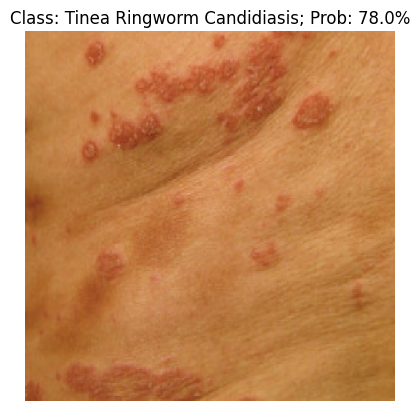

In [ ]:
predict_disease(model, dataset_path + "/Split_smol/val/Atopic Dermatitis/1_42.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Probability for each class: [('Benign keratosis', '1.00'), ('Actinic keratosis', '0.00'), ('Atopic Dermatitis', '0.00'), ('Dermatofibroma', '0.00'), ('Melanocytic nevus', '0.00'), ('Melanoma', '0.00'), ('Squamous cell carcinoma', '0.00'), ('Tinea Ringworm Candidiasis', '0.00'), ('Vascular lesion', '0.00')]


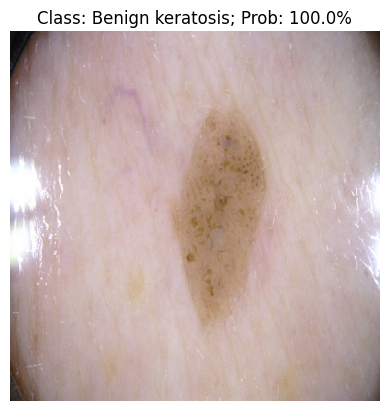

In [ ]:
predict_disease(model, dataset_path + "/Split_smol/val/Benign keratosis/ISIC_0014649_downsampled.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Probability for each class: [('Dermatofibroma', '0.80'), ('Vascular lesion', '0.13'), ('Actinic keratosis', '0.06'), ('Melanocytic nevus', '0.01'), ('Squamous cell carcinoma', '0.01'), ('Atopic Dermatitis', '0.00'), ('Benign keratosis', '0.00'), ('Melanoma', '0.00'), ('Tinea Ringworm Candidiasis', '0.00')]


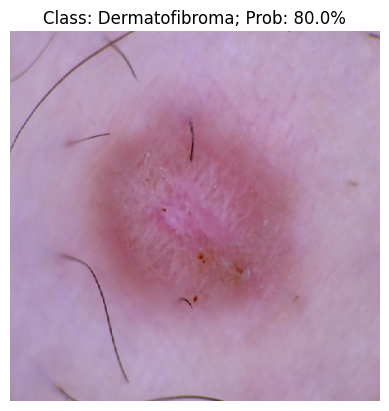

In [ ]:
predict_disease(model, dataset_path + "/Split_smol/val/Dermatofibroma/ISIC_0024330.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Probability for each class: [('Melanocytic nevus', '0.93'), ('Melanoma', '0.07'), ('Actinic keratosis', '0.00'), ('Atopic Dermatitis', '0.00'), ('Benign keratosis', '0.00'), ('Dermatofibroma', '0.00'), ('Squamous cell carcinoma', '0.00'), ('Tinea Ringworm Candidiasis', '0.00'), ('Vascular lesion', '0.00')]


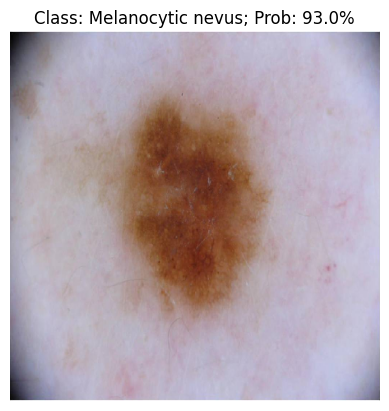

In [ ]:
predict_disease(model, dataset_path + "/Split_smol/val/Melanocytic nevus/ISIC_0000015.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Probability for each class: [('Melanoma', '0.83'), ('Melanocytic nevus', '0.07'), ('Squamous cell carcinoma', '0.06'), ('Dermatofibroma', '0.01'), ('Vascular lesion', '0.01'), ('Actinic keratosis', '0.00'), ('Atopic Dermatitis', '0.00'), ('Benign keratosis', '0.00'), ('Tinea Ringworm Candidiasis', '0.00')]


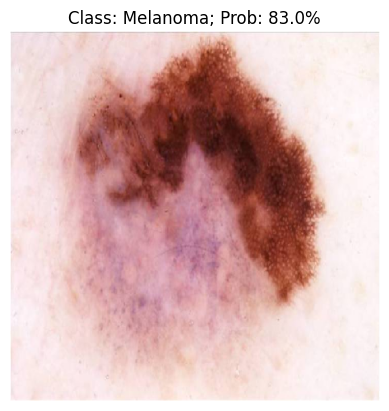

In [ ]:
predict_disease(model, dataset_path + "/Split_smol/val/Melanoma/ISIC_0000166.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Probability for each class: [('Melanoma', '0.77'), ('Melanocytic nevus', '0.16'), ('Squamous cell carcinoma', '0.05'), ('Atopic Dermatitis', '0.02'), ('Actinic keratosis', '0.00'), ('Benign keratosis', '0.00'), ('Dermatofibroma', '0.00'), ('Tinea Ringworm Candidiasis', '0.00'), ('Vascular lesion', '0.00')]


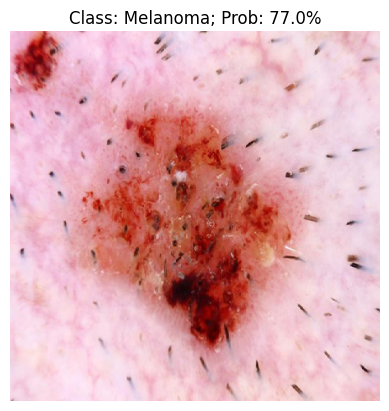

In [ ]:
predict_disease(model, dataset_path + "/Split_smol/val/Squamous cell carcinoma/ISIC_0025948.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Probability for each class: [('Tinea Ringworm Candidiasis', '0.87'), ('Atopic Dermatitis', '0.07'), ('Actinic keratosis', '0.06'), ('Benign keratosis', '0.00'), ('Dermatofibroma', '0.00'), ('Melanocytic nevus', '0.00'), ('Melanoma', '0.00'), ('Squamous cell carcinoma', '0.00'), ('Vascular lesion', '0.00')]


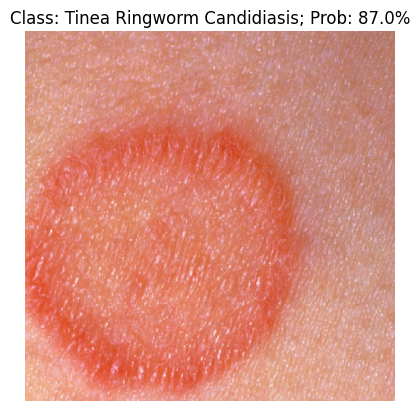

In [ ]:
predict_disease(model, dataset_path + "/Split_smol/val/Tinea Ringworm Candidiasis/aug_0_gWKFl81gOGebKIRUWg13lgp-O7X7GXiX1IOOqXBw-f2w.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Probability for each class: [('Vascular lesion', '1.00'), ('Actinic keratosis', '0.00'), ('Atopic Dermatitis', '0.00'), ('Benign keratosis', '0.00'), ('Dermatofibroma', '0.00'), ('Melanocytic nevus', '0.00'), ('Melanoma', '0.00'), ('Squamous cell carcinoma', '0.00'), ('Tinea Ringworm Candidiasis', '0.00')]


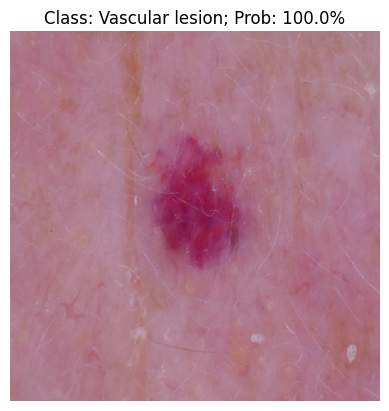

In [ ]:
predict_disease(model, dataset_path + "/Split_smol/val/Vascular lesion/ISIC_0024747.jpg")

In [ ]:
model.save('skin_disease_detect_model.keras')